In [40]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
from gymnasium.wrappers import RescaleAction
from torch import nn


In [23]:
env = gym.make("Pendulum-v1")

In [24]:
min_action, max_action = -1, 1
env = RescaleAction(env, min_action, max_action)

In [25]:
env.observation_space.sample().shape

(3,)

In [41]:
class RewardNet(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_size=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + action_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, observations, actions):
        """
        Args:
            observations (torch.Tensor): (B, obs_dim)
            actions (torch.Tensor): (B, action_dim)

        Returns:
            q_values: (torch.Tensor): (B, 1)
        """
        input = torch.cat((observations, actions), dim=1)
        return self.net(input)

In [42]:
def original_reward(state, action):
    theta, theta_dot = state
    cost = theta**2 + 0.1 * theta_dot**2 + 0.001 * action**2
    return -cost

In [71]:
def nn_reward(state, action):
    reward_net = RewardNet(3, 1)

    theta, thetadot = state
    observation = np.array([np.cos(theta), np.sin(theta), thetadot], dtype=np.float32)

    observation_t = torch.tensor(observation.reshape(1, -1), dtype=torch.float32)
    action_t = torch.tensor(action.reshape(1, -1), dtype=torch.float32)

    reward_t = reward_net(observation_t, action_t)
    reward = reward_t.item()

    return reward
    

In [72]:
def plot_rewards(reward_fn):

    theta_ls = np.linspace(-np.pi, np.pi)
    theta_dot_ls = np.linspace(-1, 1)
    action_ls = np.linspace(-1, 1)

    state = np.array([0, 0], dtype=np.float32)
    action = np.array(0)

    rewards = []
    for theta in theta_ls:
        state[0] = theta
        reward = reward_fn(state, action)
        rewards.append(reward)

    plt.plot(theta_ls, rewards)

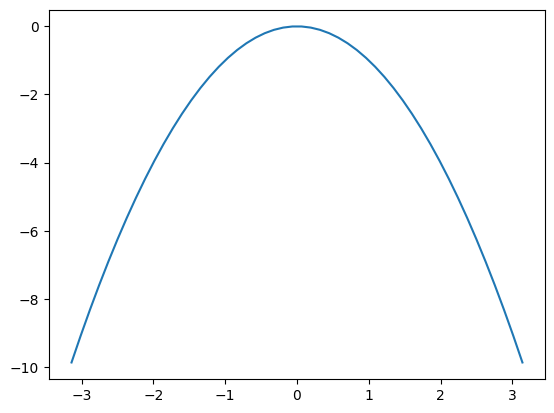

In [73]:
plot_rewards(original_reward)

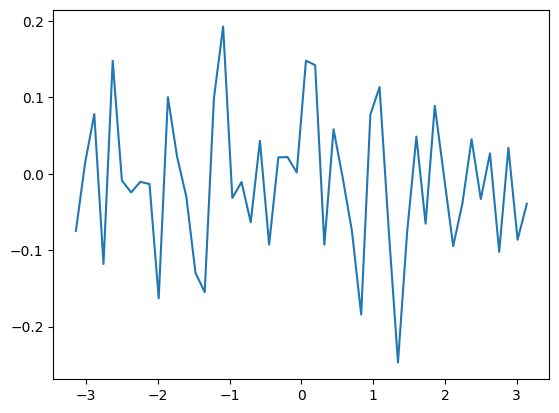

In [74]:
plot_rewards(nn_reward)